In [338]:
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import layers, models, optimizers, utils, backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os
import cv2

In [339]:
def read_image(filename):
    WIDTH, HEIGHT, MAXVAL, OFFSET = 92, 112, 255, 14
    with open(filename, 'rb') as f:
        buffer = f.read()
    arr = np.frombuffer(buffer, dtype='u1', count=WIDTH*HEIGHT, offset=OFFSET )
    return arr.reshape((HEIGHT, WIDTH))

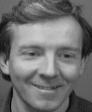

In [340]:
Image.open('data/s3/1.pgm')

In [341]:
size = 2
total_sample_size = 400

def get_data(size, total_sample_size):
    image = read_image('data/s1/1.pgm')
    image = image[::size, ::size]
    dim1, dim2 = image.shape[0], image.shape[1]
    count = 0
    
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            img1 = read_image('data/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm')
            img2 = read_image('data/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm')
            
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('data/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm')
            img2 = read_image('data/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            y_imposite[count] = 0
            count += 1
            
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0) / 255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [342]:
X, Y = get_data(size, total_sample_size)
X = np.swapaxes(X, 2, 4)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [343]:
def build_base_network(input_shape):
    seq = models.Sequential()    
    seq.add(layers.Convolution2D(8, 3, 3, input_shape=input_shape))
    seq.add(layers.Activation('elu'))
    seq.add(layers.MaxPooling2D(pool_size=(2, 2))) 
    seq.add(layers.Dropout(0.1))
    seq.add(layers.Flatten())
    seq.add(layers.Dense(128, activation='elu'))
    seq.add(layers.Dropout(0.1))
    seq.add(layers.Dense(64, activation='elu'))
    return seq

In [344]:
x_train.shape[2:]

(46, 56, 1)

In [345]:
input_dim = x_train.shape[2:]
input_a = layers.Input(shape=input_dim)
input_b = layers.Input(shape=input_dim)

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(input_a)
feat_vecs_b = base_network(input_b)

In [346]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    euclidean_distance = K.sqrt(K.maximum(sum_square, K.epsilon()))
    return euclidean_distance

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [347]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1]

epochs = 40
rms = optimizers.RMSprop()
model = models.Model(inputs=[input_a, input_b], outputs=distance)

model.compile(loss=contrastive_loss, optimizer=rms)
model.fit([img_1, img_2], y_train, batch_size=64, verbose=2, epochs=epochs)

pred = model.predict([x_test[:, 0], x_test[:, 1]]).ravel()
print('Accuracy:', y_test[pred < 0.5].mean())

Epoch 1/40


10/10 - 1s - loss: 0.4241 - 669ms/epoch - 67ms/step
Epoch 2/40
10/10 - 0s - loss: 0.2575 - 66ms/epoch - 7ms/step
Epoch 3/40
10/10 - 0s - loss: 0.2138 - 50ms/epoch - 5ms/step
Epoch 4/40
10/10 - 0s - loss: 0.1777 - 67ms/epoch - 7ms/step
Epoch 5/40
10/10 - 0s - loss: 0.1454 - 66ms/epoch - 7ms/step
Epoch 6/40
10/10 - 0s - loss: 0.1236 - 50ms/epoch - 5ms/step
Epoch 7/40
10/10 - 0s - loss: 0.1035 - 67ms/epoch - 7ms/step
Epoch 8/40
10/10 - 0s - loss: 0.0934 - 67ms/epoch - 7ms/step
Epoch 9/40
10/10 - 0s - loss: 0.0836 - 78ms/epoch - 8ms/step
Epoch 10/40
10/10 - 0s - loss: 0.0760 - 76ms/epoch - 8ms/step
Epoch 11/40
10/10 - 0s - loss: 0.0694 - 91ms/epoch - 9ms/step
Epoch 12/40
10/10 - 0s - loss: 0.0655 - 98ms/epoch - 10ms/step
Epoch 13/40
10/10 - 0s - loss: 0.0626 - 89ms/epoch - 9ms/step
Epoch 14/40
10/10 - 0s - loss: 0.0596 - 112ms/epoch - 11ms/step
Epoch 15/40
10/10 - 0s - loss: 0.0549 - 60ms/epoch - 6ms/step
Epoch 16/40
10/10 - 0s - loss: 0.0524 - 67ms/epoch - 7ms/step
Epoch 17/40
10/10 - 0s 

In [351]:
NUM_CLASS = 40

X,y=[], []
for i in range(1, NUM_CLASS + 1):
	images = os.listdir('./data/s'+str(i))
	for image in images:
		img = cv2.imread('./data/s'+str(i)+'/'+image, 0)
		height1, width1 = img.shape[:2]
		img_col = np.array(img, dtype='float64').flatten()
		subject = int(i)
		X.append(img_col)
		y.append(subject)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n_components = NUM_CLASS
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

clf = SVC(kernel='rbf', class_weight='balanced', gamma=0.0005, C=1000)
clf = clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         1
          19       1.00    

In [352]:
X_tr = np.array(X_train_pca)
X_te = np.array(X_test_pca)
y_train_cat = utils.to_categorical(y_train)
y_test_cat = utils.to_categorical(y_test)

m = models.Sequential()
m.add(layers.Dense(512, input_shape=(X_tr.shape[1],), activation='elu'))
m.add(layers.Dense(256, activation='elu'))
m.add(layers.Dropout(0.2))
m.add(layers.Dense(256, activation='elu'))
m.add(layers.Dropout(0.2))
m.add(layers.Dense(128, activation='elu'))
m.add(layers.Dropout(0.2))
m.add(layers.Dense(64, activation='elu'))
m.add(layers.Dense(NUM_CLASS + 1, activation='softmax'))
sgd = optimizers.SGD(0.01)
m.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics = ['accuracy'])

m.fit(X_tr, y_train_cat, batch_size=64, epochs=100)
print('Точность:', m.evaluate(X_te, y_test_cat)[1])

Epoch 1/100
5/5 [==============================] - 0s 4ms/step - loss: 3.7949 - accuracy: 0.0312
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 3.7395 - accuracy: 0.0312
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 3.7230 - accuracy: 0.0562
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 3.7451 - accuracy: 0.0375
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 3.6935 - accuracy: 0.0594
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 3.6562 - accuracy: 0.0594
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 3.6249 - accuracy: 0.0656
Epoch 8/100
5/5 [==============================] - 0s 2ms/step - loss: 3.6078 - accuracy: 0.0656
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 3.5573 - accuracy: 0.1063
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 3.5517 - accuracy: 0.1031
Epoch 11/100
5/5 [===========

In [350]:
X_tr = np.array(X_train).reshape(-1, 92, 112, 1) / 255
X_te = np.array(X_test).reshape(-1, 92, 112, 1) / 255
y_train_cat = utils.to_categorical(y_train)
y_test_cat = utils.to_categorical(y_test)

m = models.Sequential()    
m.add(layers.Convolution2D(8, 3, 3, input_shape=X_tr.shape[1:]))
m.add(layers.Activation('elu'))
m.add(layers.MaxPooling2D(pool_size=(2, 2))) 
m.add(layers.Dropout(0.1))
m.add(layers.Flatten())
m.add(layers.Dense(128, activation='elu'))
m.add(layers.Dropout(0.1))
m.add(layers.Dense(64, activation='elu'))
m.add(layers.Dense(NUM_CLASS + 1, activation='softmax'))

sgd = optimizers.SGD(0.01)
m.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics = ['accuracy'])

m.fit(X_tr, y_train_cat, batch_size=64, epochs=100)
print('Точность:', m.evaluate(X_te, y_test_cat)[1])

Epoch 1/100
3/3 [==============================] - 0s 16ms/step - loss: 3.1414 - accuracy: 0.0375
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 3.0761 - accuracy: 0.0562
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 3.0718 - accuracy: 0.0562
Epoch 4/100
3/3 [==============================] - 0s 11ms/step - loss: 3.0560 - accuracy: 0.0562
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 3.0494 - accuracy: 0.0875
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 3.0210 - accuracy: 0.0625
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 3.0246 - accuracy: 0.0812
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 3.0104 - accuracy: 0.0562
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 3.0104 - accuracy: 0.0688
Epoch 10/100
3/3 [==============================] - 0s 11ms/step - loss: 3.0214 - accuracy: 0.0875
Epoch 11/100
3/3 [=====